# Lab 4 - Multilayer Perceptron
Team members:
- Sam Yao
- Rebecca Kuhlman
- Michael Amberg

## Objective

The objective of this lab is to familiarize ourselves with MultiLayer Neural Networks. This will be done through predicting, for each county, the level of child poverty. You will need to convert this from regression to four levels of classification by quantizing the variable of interest.

1) Load the data into memory and save it to a pandas data frame. Do not normalize or one-hot encode any of the features until asked to do so later in the rubric.

In [1]:
import pandas as pd
import numpy as np

df_census_raw = pd.read_csv("acs2017_census_tract_data.csv")

In [2]:
df_census_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74001 entries, 0 to 74000
Data columns (total 37 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   TractId           74001 non-null  int64  
 1   State             74001 non-null  object 
 2   County            74001 non-null  object 
 3   TotalPop          74001 non-null  int64  
 4   Men               74001 non-null  int64  
 5   Women             74001 non-null  int64  
 6   Hispanic          73305 non-null  float64
 7   White             73305 non-null  float64
 8   Black             73305 non-null  float64
 9   Native            73305 non-null  float64
 10  Asian             73305 non-null  float64
 11  Pacific           73305 non-null  float64
 12  VotingAgeCitizen  74001 non-null  int64  
 13  Income            72885 non-null  float64
 14  IncomeErr         72885 non-null  float64
 15  IncomePerCap      73256 non-null  float64
 16  IncomePerCapErr   73256 non-null  float6

2) Remove any observations that having missing data. 

Source used for this section:
- https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html

In [3]:
df_census_raw = df_census_raw.dropna() #Utilized the pandas documentation here

In [4]:
df_census_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72718 entries, 0 to 74000
Data columns (total 37 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   TractId           72718 non-null  int64  
 1   State             72718 non-null  object 
 2   County            72718 non-null  object 
 3   TotalPop          72718 non-null  int64  
 4   Men               72718 non-null  int64  
 5   Women             72718 non-null  int64  
 6   Hispanic          72718 non-null  float64
 7   White             72718 non-null  float64
 8   Black             72718 non-null  float64
 9   Native            72718 non-null  float64
 10  Asian             72718 non-null  float64
 11  Pacific           72718 non-null  float64
 12  VotingAgeCitizen  72718 non-null  int64  
 13  Income            72718 non-null  float64
 14  IncomeErr         72718 non-null  float64
 15  IncomePerCap      72718 non-null  float64
 16  IncomePerCapErr   72718 non-null  float6

3) Encode any string data as integers for now.

There are two categories that are not numerical: State and County.

I encoded the states and individual counties as nominal types, where each number corresponds to a unique county and state, and has no ranking whatsoever.

In [5]:
#Map States to a number
states_mapping = {state: label for label, state in enumerate(df_census_raw.State.unique())}
df_census_raw['State'] = df_census_raw['State'].map(states_mapping)

#Map Counties to a number
county_mapping = {county: label for label, county in enumerate(df_census_raw.County.unique())}
df_census_raw['County'] = df_census_raw['County'].map(county_mapping)

We have decided to remove the county variable. While county can be a indicator of childhood poverty, due to the limited amount of entries for each county, the data will likely be biased on what data ends up in the training set.

In [6]:
df_census_raw.County.value_counts()

186     2300
366     1317
196      929
103      885
50       822
        ... 
1755       1
1066       1
663        1
1065       1
1651       1
Name: County, Length: 1954, dtype: int64

<AxesSubplot: >

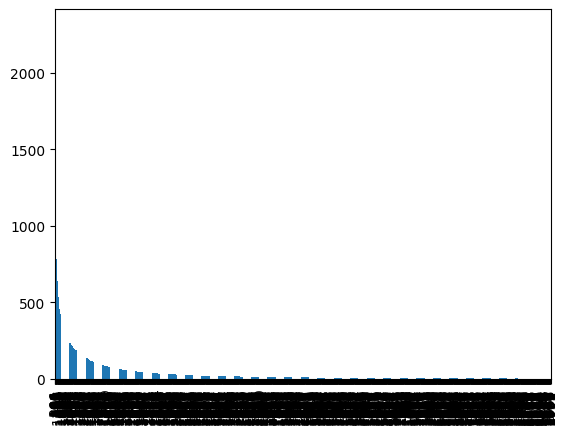

In [7]:
import matplotlib.pyplot as plt

df_census_raw.County.value_counts().plot.bar()

Even without this handy visualization, one can see that there are too many counties with too few data points to  begin analysis on child poverty. Although there certainly are patterns as to which counties in a state are more likely to have children in poverty, leaving the county attribute as it is would most likely introduce bias towards the counties that have the highest rates of child poverty. Since child poverty is certainly influenced by several other factors other than physical county location, we think it is best to remove Counties as an attribute from the dataset.

In [8]:
df_census_raw = df_census_raw.drop(labels='County',axis=1)

In [9]:
df_census_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72718 entries, 0 to 74000
Data columns (total 36 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   TractId           72718 non-null  int64  
 1   State             72718 non-null  int64  
 2   TotalPop          72718 non-null  int64  
 3   Men               72718 non-null  int64  
 4   Women             72718 non-null  int64  
 5   Hispanic          72718 non-null  float64
 6   White             72718 non-null  float64
 7   Black             72718 non-null  float64
 8   Native            72718 non-null  float64
 9   Asian             72718 non-null  float64
 10  Pacific           72718 non-null  float64
 11  VotingAgeCitizen  72718 non-null  int64  
 12  Income            72718 non-null  float64
 13  IncomeErr         72718 non-null  float64
 14  IncomePerCap      72718 non-null  float64
 15  IncomePerCapErr   72718 non-null  float64
 16  Poverty           72718 non-null  float6

In [10]:
df_census_raw['ChildPoverty'].describe()

count    72718.000000
mean        21.148476
std         18.572714
min          0.000000
25%          6.200000
50%         16.300000
75%         31.600000
max        100.000000
Name: ChildPoverty, dtype: float64

(array([25612., 15946., 11393.,  7936.,  5289.,  3352.,  1810.,   887.,
          345.,   148.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <BarContainer object of 10 artists>)

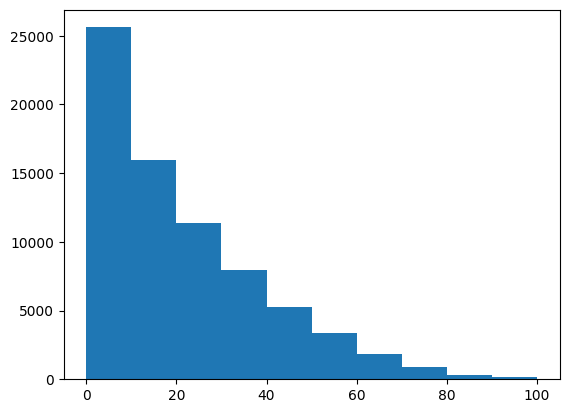

In [11]:
import matplotlib.pyplot as plt
plt.hist(df_census_raw.ChildPoverty)

[.5 points] Balance the dataset so that about the same number of instances are within each class. Choose a method for balancing the dataset and explain your reasoning for selecting this method. One option is to choose quantization thresholds for the "ChildPoverty" variable that equally divide the data into four classes. Should balancing of the dataset be done for both the training and testing set? Explain.


Utilized Code Sourced here:
- https://pandas.pydata.org/docs/reference/api/pandas.qcut.html

In [12]:
#Looked at Documentation for pandas.qcut()

df_census_raw.ChildPoverty, bins= pd.qcut(df_census_raw.ChildPoverty, 4,labels=[1,2,3,4], retbins=True)
df_census_raw.astype({'ChildPoverty': 'int64'}).dtypes

TractId               int64
State                 int64
TotalPop              int64
Men                   int64
Women                 int64
Hispanic            float64
White               float64
Black               float64
Native              float64
Asian               float64
Pacific             float64
VotingAgeCitizen      int64
Income              float64
IncomeErr           float64
IncomePerCap        float64
IncomePerCapErr     float64
Poverty             float64
ChildPoverty          int64
Professional        float64
Service             float64
Office              float64
Construction        float64
Production          float64
Drive               float64
Carpool             float64
Transit             float64
Walk                float64
OtherTransp         float64
WorkAtHome          float64
MeanCommute         float64
Employed              int64
PrivateWork         float64
PublicWork          float64
SelfEmployed        float64
FamilyWork          float64
Unemployment        

For quantization, we went with splitting the target output into four different bins using equal frequency. For training and testing, it would be important to balance the datasets. This is because if you don't balance the dataset, this could end in a situation where there are too many of one variable in the test dataset, but not the training dataset, and this would cause the model to perform poorly.

In this particular case, we are shuffling the train_test_split method to balance this out.

The balancing of the data is not necessary for the testing set. In reality, a deployed algorithm will not encounter balanced data. The balanced data is important in the training set as it makes sure the model will be able to predict data across the board in a non-biased way. Testing data does not influence the algorithm directly, though it is important to test a variety of circumstances before deployment.

In [13]:
from sklearn.model_selection import train_test_split

X = df_census_raw[["State","TotalPop", "Men", "Women", "Hispanic","White","Black","Native", "Asian", "Pacific",
               "VotingAgeCitizen","Income", "IncomeErr", "IncomePerCap", "IncomePerCapErr","Professional","Service","Office", "Construction", "Production","Drive", "Carpool", "Transit", "Walk","OtherTransp","WorkAtHome","MeanCommute", "Employed", "PrivateWork",
               "PublicWork","SelfEmployed", "FamilyWork", "Unemployment"]]
#Include poverty?

y = df_census_raw[["ChildPoverty"]]

(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size = .2, shuffle=True)

Pre-processing and Initial Modeling (2.5 points total)
        You will be using a two layer perceptron from class for the next few parts of the rubric. There are several versions of the two layer perceptron covered in class, with example code. When selecting an example two layer network from class be sure that you use: (1) vectorized gradient computation, (2) mini-batching, (3) cross entropy loss, and (4) proper Glorot initialization, at a minimum. There is no need to use momentum or learning rate reduction (assuming you choose a sufficiently small learning rate). It is recommended to use sigmoids throughout the network, but not required.
        [.5 points] Use the example two-layer perceptron network from the class example and quantify performance using accuracy. Do not normalize or one-hot encode the data (not yet). Be sure that training converges by graphing the loss function versus the number of epochs.



In [14]:
#Example adapted from https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch12/ch12.ipynb
#Original Author: Sebastian Raschka

import numpy as np
from scipy.special import expit
import sys
import pandas as pd

# start with a simple base classifier, which can't be fit or predicted
# it only has internal classes to be used by classes that will subclass it
# Start with the following functions:
#    init
#    encode_labels
#    initialize weights
#    sigmoid
#    add bias (vector of ones)
#    objective function (cost and regularizer)
class TwoLayerPerceptronBase(object):
    def __init__(self, n_hidden=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta

    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T

        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        W1_num_elems = (self.n_features_ + 1)*self.n_hidden
        W1 = np.random.uniform(-1.0, 1.0, size=W1_num_elems)
        W1 = W1.reshape(self.n_hidden, self.n_features_ + 1) # reshape to be W

        W2_num_elems = (self.n_hidden + 1)*self.n_output_
        W2 = np.random.uniform(-1.0, 1.0, size=W2_num_elems)
        W2 = W2.reshape(self.n_output_, self.n_hidden + 1)
        return W1, W2

    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)

    @staticmethod
    def _add_bias_unit(X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new

    @staticmethod
    def _L2_reg(lambda_, W1, W2):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2))

    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''
        cost = np.mean((Y_enc-A3)**2)
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term

In [15]:
# now let's add in the following functions:
#    feedforward
#    fit and predict
class TwoLayerPerceptron(TwoLayerPerceptronBase):
    def _feedforward(self, X, W1, W2):
        """Compute feedforward step
        -----------
        X : Input layer with original features.
        W1: Weight matrix for input layer -> hidden layer.
        W2: Weight matrix for hidden layer -> output layer.
        ----------
        a1-a3 : activations into layer (or output layer)
        z1-z2 : layer inputs

        """
        A1 = self._add_bias_unit(X.T, how='row')
        Z1 = W1 @ A1
        A2 = self._sigmoid(Z1)
        A2 = self._add_bias_unit(A2, how='row')
        Z2 = W2 @ A2
        A3 = self._sigmoid(Z2)
        return A1, Z1, A2, Z2, A3

    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # need to vectorize this computation!
        # See additional code and derivation below!

    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, A3 = self._feedforward(X, self.W1, self.W2)
        y_pred = np.argmax(A3, axis=0)
        return y_pred


    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data."""

        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)

        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2 = self._initialize_weights()

        self.cost_ = []
        for i in range(self.epochs):

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            # feedforward all instances
            A1, Z1, A2, Z2, A3 = self._feedforward(X_data,self.W1,self.W2)

            cost = self._cost(A3,Y_enc,self.W1,self.W2)
            self.cost_.append(cost)

            # compute gradient via backpropagation
            grad1, grad2 = self._get_gradient(A1=A1, A2=A2, A3=A3, Z1=Z1, Z2=Z2, Y_enc=Y_enc,
                                              W1=self.W1, W2=self.W2)

            self.W1 -= self.eta * grad1
            self.W2 -= self.eta * grad2


        return self

In [16]:
params = dict(n_hidden=50,
              C=0.1, # tradeoff L2 regularizer
              epochs=400, # iterations
              eta=0.001,  # learning rate
              random_state=1)


In [17]:
class TwoLayerPerceptronVectorized(TwoLayerPerceptron):
    # just need a different gradient calculation
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V2 = -2*(Y_enc-A3)*A3*(1-A3)
        V1 = A2*(1-A2)*(W2.T @ V2)

        grad2 = V2 @ A2.T
        grad1 = V1[1:,:] @ A1.T


        # regularize weights that are not bias terms
        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C

        return grad1, grad2

In [19]:
from sklearn.metrics import accuracy_score
nn = TwoLayerPerceptronVectorized(**params)

nn.fit(X_train, y_train, print_progress=50)
yhat = nn.predict(X_test)
print('Accuracy:',accuracy_score(y_test,yhat))

Epoch: 400/400

Accuracy: 0.24518701870187018


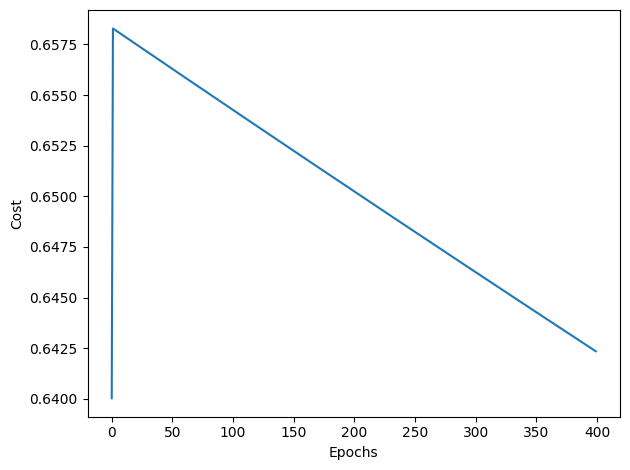

In [21]:
plt.plot(range(len(nn.cost_)), nn.cost_)
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

Minibatch:

In [24]:
# Example adapted from https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch12/ch12.ipynb
# Original Author: Sebastian Raschka
# This is the optional book we use in the course, excellent intuitions and straightforward programming examples
# please note, however, that this code has been manipulated to reflect our assumptions and notation.
class TLPVectorizedMiniBatch(TwoLayerPerceptronVectorized):
    def __init__(self, alpha=0.1, decrease_const=0.0, shuffle=True, minibatches=1, **kwds):
        # need to add to the original initializer
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches
        # but keep other keywords
        super().__init__(**kwds)

    def fit(self, X, y, print_progress=0):
        """ Learn weights from training data."""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)

        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2 = self._initialize_weights()

        # start momentum at zero for previous updates
        rho_W1_prev = np.zeros(self.W1.shape) # for momentum
        rho_W2_prev = np.zeros(self.W2.shape) # for momentum

        self.cost_ = []
        for k in range(self.epochs):

            # adaptive learning rate
            eta = self.eta**(1+self.decrease_const*k)# decreasing learning rate
            eta = max(eta,self.eta/1000)
            # there are many forms of adaptive learning rates out there!

            if print_progress>0 and (k+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (k+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                ridx = np.random.permutation(y_data.shape[0])
                X_data, Y_enc = X_data[ridx], Y_enc[:, ridx]

            # use numpy split to split into equal sized batches
            # num batches== self.minibatches
            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:

                # feedforward
                A1, Z1, A2, Z2, A3 = self._feedforward(X_data[idx],
                                                       self.W1,
                                                       self.W2)

                cost = self._cost(A3,Y_enc[:, idx],self.W1,self.W2)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                grad1, grad2 = self._get_gradient(A1=A1, A2=A2, A3=A3, Z1=Z1, Z2=Z2,
                                                  Y_enc=Y_enc[:, idx],
                                                  W1=self.W1, W2=self.W2)

                rho_W1, rho_W2 = eta * grad1, eta * grad2
                self.W1 -= (rho_W1 + (self.alpha * rho_W1_prev)) # update with momentum
                self.W2 -= (rho_W2 + (self.alpha * rho_W2_prev)) # update with momentum
                rho_W1_prev, rho_W2_prev = rho_W1, rho_W2

            self.cost_.append(mini_cost)

        return self

In [25]:
%%time
params['epochs'] = 100
params['eta'] = 0.1
nn_mini = TLPVectorizedMiniBatch(**params,
                          alpha=0.1,# momentum calculation
                          decrease_const=0.1, # decreasing eta
                          minibatches=len(X_train)/32, # minibatch size
                          shuffle=True)


nn_mini.fit(X_train, y_train, print_progress=50)
yhat = nn.predict(X_test)
print('Accuracy:',accuracy_score(y_test,yhat))

KeyError: "None of [Int64Index([21867, 49690, 45690,   246, 27517, 14274,  8817, 52837, 52633,\n            28037,\n            ...\n            57236, 50501, 56373, 17250,  5223, 51951, 49761, 10609,   915,\n            50919],\n           dtype='int64', length=58174)] are in the [columns]"

In [20]:
# take the mean of each minibatch epoch
cost_avgs = [np.mean(x) for x in nn_mini.cost_]

plt.plot(range(len(cost_avgs)), cost_avgs, color='red')
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

NameError: name 'nn_mini' is not defined

In [ ]:
from scipy.optimize import fmin_bfgs
from scipy.optimize import fmin_l_bfgs_b
class TLPVectorizedBFGS(TwoLayerPerceptronVectorized):

    def __init__(self, gtol=1e-5, **kwds):
        # need to add to the original initializer
        self.gtol = gtol

        # but keep other keywords
        super().__init__(**kwds)

    @staticmethod
    def _pack(in1, in2):
        '''Pack and flatten input vectors '''
        return np.hstack((in1.flatten(),in2.flatten()))

    def _unpack(self, in_tot):
        '''Undo packing according to layer weight sizes'''
        out1 = in_tot[:self.W1.size].reshape(self.W1.shape)
        out2 = in_tot[self.W1.size:].reshape(self.W2.shape)
        return out1, out2

    def _calc_cost_gradient_packed(self,W,X_data,Y_enc):
        '''Unpack and get cost, gradient for bfgs'''
        W1, W2 = self._unpack(W)
        # feedforward all instances
        A1, Z1, A2, Z2, A3 = self._feedforward(X_data,W1,W2)

        cost = np.sum((Y_enc-A3)**2)
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        cost = cost + L2_term
        #perform back prop to get gradients
        grad1,grad2 = self._get_gradient(A1=A1, A2=A2, A3=A3,Z1=Z1, Z2=Z2, Y_enc=Y_enc,
                                         W1=W1, W2=W2)
        return cost, self._pack(grad1,grad2)

    def _cost_packed(self,W,X_data,Y_enc):
        '''Unpack and calculate MSE for bfgs'''
        W1, W2 = self._unpack(W)
        _, _, _, _, A3 = self._feedforward(X_data,W1,W2)
        return np.sum((Y_enc-A3)**2)

    def fit(self,X,y,print_progress=0):
        '''Learn weights from training data'''
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)

        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2 = self._initialize_weights()

        # make initial matrices into single row vector
        W = self._pack(self.W1,self.W2)

        if print_progress>0:
            def callback(xd):
                callback.counter += 1
                if callback.counter%print_progress==0:
                    sys.stderr.write('\rEpoch: %d/%d (max)' % (callback.counter,callback.epochs))
                    sys.stderr.flush()

            callback.counter = 0
            callback.epochs = self.epochs

        else:
            callback = None

        # compute gradient optimum with bfgs
        W_best,_,props = fmin_l_bfgs_b(
                        x0=W,
                        func=self._calc_cost_gradient_packed,
                        maxfun=self.epochs,
                        callback=callback,
                        pgtol=self.gtol,
                        args=(X_data, Y_enc))

        self.W1, self.W2 = self._unpack(W_best)
        if print_progress:
            print(props)

In [ ]:
from sklearn.metrics import accuracy_score
%%time
nn_bfgs = TLPVectorizedBFGS(**params, gtol=1e-3)

nn_bfgs.fit(X_train, y_train, print_progress=1)
yhat = nn_bfgs.predict(X_test)
print('Accuracy:',accuracy_score(y_test,yhat))

[.5 points] Now (1) normalize the continuous numeric feature data. Use the example two-layer perceptron network from the class example and quantify performance using accuracy. Be sure that training converges by graphing the loss function versus the number of epochs.
        [.5 points] Now(1) normalize the continuous numeric feature data AND (2) one hot encode the categorical data. Use the example two-layer perceptron network from the class example and quantify performance using accuracy. Be sure that training converges by graphing the loss function versus the number of epochs.
        [1 points] Compare the performance of the three models you just trained. Are there any meaningful differences in performance? Explain, in your own words, why these models have (or do not have) different performances.
            Use one-hot encoding and normalization on the dataset for the remainder of this lab assignment.

Modeling (5 points total)
        [1 points] Add support for a third layer in the multi-layer perceptron. Add support for saving (and plotting after training is completed) the average magnitude of the gradient for each layer, for each epoch (like we did in the flipped module for back propagation). For magnitude calculation, you are free to use either the average absolute values or the L1/L2 norm.
            Quantify the performance of the model and graph the magnitudes for each layer versus the number of epochs.
        [1 points] Repeat the previous step, adding support for a fourth layer.
        [1 points] Repeat the previous step, adding support for a fifth layer.
        [2 points] Implement an adaptive learning technique that was discussed in lecture and use it on the five layer network (such as AdaGrad, RMSProps, or AdaDelta).
         Discuss which adaptive method you chose.
         Compare the performance of your five layer model with and without the adaptive learning strategy. Do not use AdaM.

Exceptional Work (1 points total)
       Implement adaptive momentum (AdaM) in the five layer neural network and quantify the performance.